notebook generates rebinned spectra and physical quantities, given specified integration time 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import optimize
from scipy.optimize import curve_fit

import sys
sys.path.append("../")
from create_arrays import siiv

In [2]:
# import arrays
tube = readsav('/Users/WilliamHenryAshfieldIV/dat/f2020_ebtel/ebtel_l85_h100_subI.sav',verbose=False,python_dict=False)
frac = readsav('/Users/WilliamHenryAshfieldIV/dat/f2020_ebtel/ebtel_l85_h100_subI_si_iv_nei.sav',verbose=False,python_dict=False)
log10T,log10G = np.loadtxt('/Users/WilliamHenryAshfieldIV/dat/goft_1403.dat.txt',comments='%',unpack=True)

In [3]:
t_n = tube.tarr.shape[0] - 1 # len of tube in time (in steps of 0.1s)
line = 1402.77

../create_arrays.py:70: RuntimeWarning: invalid value encountered in true_divide
  temp_fac = f_nei/f_eqi
../create_arrays.py:130: RuntimeWarning: invalid value encountered in true_divide
  factor = nei/eqi
../create_arrays.py:184: RuntimeWarning: invalid value encountered in sqrt
  meas_error = np.sqrt(tot_emissNEI) # error measured


(1402.0, 1404.0)

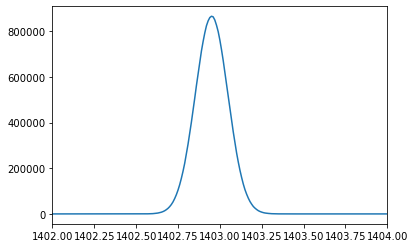

In [4]:
k = 125
arrs = siiv(tube,frac,log10T,log10G,time=k)
plt.plot(arrs.wav,arrs.spec)
plt.xlim(1402,1404)

In [5]:
ll = arrs.wav

In [6]:
arrs.rebin()

reshape index =  25


../create_arrays.py:70: RuntimeWarning: invalid value encountered in true_divide
  temp_fac = f_nei/f_eqi
../create_arrays.py:130: RuntimeWarning: invalid value encountered in true_divide
  factor = nei/eqi
../create_arrays.py:184: RuntimeWarning: invalid value encountered in sqrt
  meas_error = np.sqrt(tot_emissNEI) # error measured
../create_arrays.py:130: RuntimeWarning: divide by zero encountered in true_divide
  factor = nei/eqi
../create_arrays.py:171: RuntimeWarning: overflow encountered in double_scalars
  emissNEI[i,:] = photo_fac*EM[i]*factor[i]*10**g[i]/np.sqrt(2*np.pi)/sig[i]*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))
../create_arrays.py:171: RuntimeWarning: invalid value encountered in double_scalars
  emissNEI[i,:] = photo_fac*EM[i]*factor[i]*10**g[i]/np.sqrt(2*np.pi)/sig[i]*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))


number of time elements after rebin:  36


Text(0.5, 0, 'wavelength [$\\AA$]')

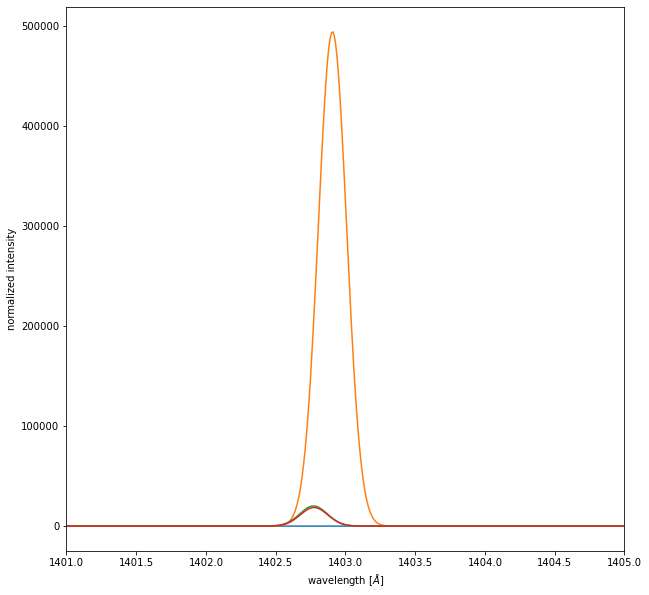

In [7]:
fig, ax = plt.subplots(figsize=[10,10])
plt.plot(ll,arrs.respec[0,:])
plt.plot(ll,arrs.respec[5,:])
plt.plot(ll,arrs.respec[10,:])
plt.plot(ll,arrs.respec[15,:])
plt.xlim(1401,1405)
plt.ylabel('normalized intensity')
ax.set_xlabel('wavelength [$\AA$]')

In [8]:
arrs.respec.shape

(36, 2000)

# Time series of synthetic spectrum:

In [9]:
arrs.fitspec()

nt =  36


(0.0, 50.0)

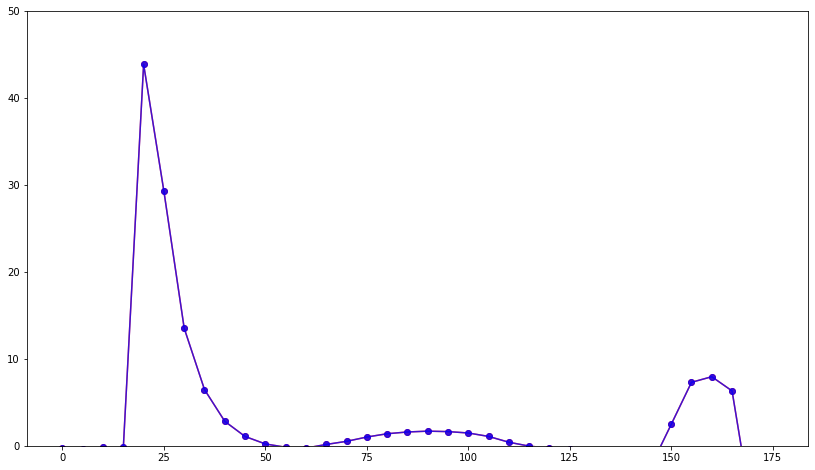

In [10]:
plt.figure(figsize=(14,8))
plt.plot(arrs.time,arrs.vr,'r',alpha=0.75,marker='o')
plt.plot(arrs.time,arrs.vb,'b',alpha=0.75,marker='o')
plt.ylim(0,50)

In [48]:
arrs.vr[4]
arrs.time[4]-sttime

20.0

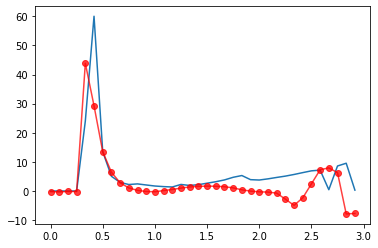

In [11]:
plt.plot(arrs.time/60,arrs.amp/np.max(arrs.amp)*60)
plt.plot(arrs.time/60,arrs.vr,'r',alpha=0.75,marker='o')

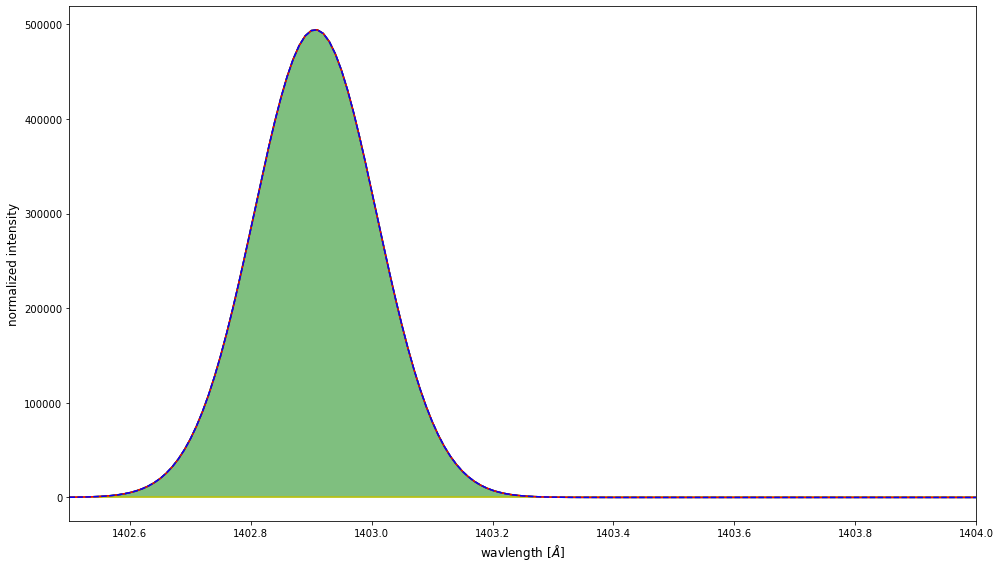

In [12]:
arrs.plotgauss(itime=5)

# Fit:

In [13]:
def u0_fit(t, *a):
    return a[0]/(1+t/a[1])

In [14]:
imax = np.argmax(arrs.vr) 

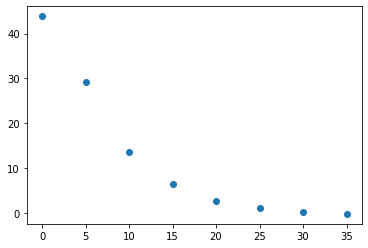

In [15]:
tt = arrs.time[imax:imax+8]
tt = tt-tt[0]
vr = arrs.vr[imax:imax+8]
plt.plot(tt,vr,'o')

In [16]:
a0= [arrs.vr[imax],6]
popt, pcov = curve_fit(u0_fit, tt, vr,p0=a0)

In [17]:
preft_fit = u0_fit(tt,*popt)
f = interp1d(tt,preft_fit,kind='cubic')

In [18]:
tnew = np.linspace(tt[0], tt[-1], num=51, endpoint=True)

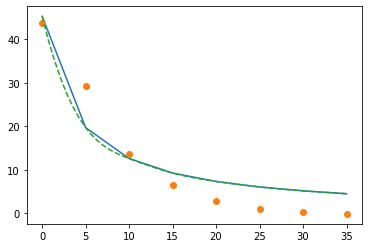

In [19]:
plt.plot(tt,u0_fit(tt,*popt))
plt.plot(tt,vr,'o')
plt.plot(tnew,f(tnew),'--')

In [20]:
popt[1]

3.8417685731860125

In [21]:
H = 0.6*popt[0]*popt[1]

In [22]:
H

104.43665273649704

 # Move to CCSDS time

In [23]:
import datetime
import matplotlib.dates as date

In [24]:
aiatime = readsav('/Users/WilliamHenryAshfieldIV/dat/aia2preft_ccsds.sav',verbose=False,python_dict=False)

In [25]:
aiatime

{'aiat': array([b'2014-10-25T17:04:14.630', b'2014-10-25T17:04:14.830',
        b'2014-10-25T17:04:15.030', ..., b'2014-10-25T17:34:14.230',
        b'2014-10-25T17:34:14.430', b'2014-10-25T17:34:14.630'],
       dtype=object)}

In [26]:
aiatm = np.array(aiatime.aiat)

In [27]:
aiatm = aiatm[0:900]

In [28]:
aiatm[0]

b'2014-10-25T17:04:14.630'

In [29]:
tm = arrs.time
sttime = 61454.63 # observation start time in sec.
tm += sttime # observation start time in sec.

In [30]:
dts = np.empty(len(tm), dtype = '<U15')
for i in range (0,len(tm)):
    dts[i] = str(datetime.timedelta(seconds=tm[i],milliseconds=3))

In [31]:
dts[5]

'17:04:39.633000'

In [32]:
tmp = np.array([datetime.datetime for x in range(len(tm))])
for i in range(0,len(tm)):
    tmp[i]=datetime.datetime.strptime(dts[i],'%H:%M:%S.%f')
tm_d = date.date2num(tmp)

In [33]:
stm_d = tm_d[imax:imax+8]

(0.0, 45.0)

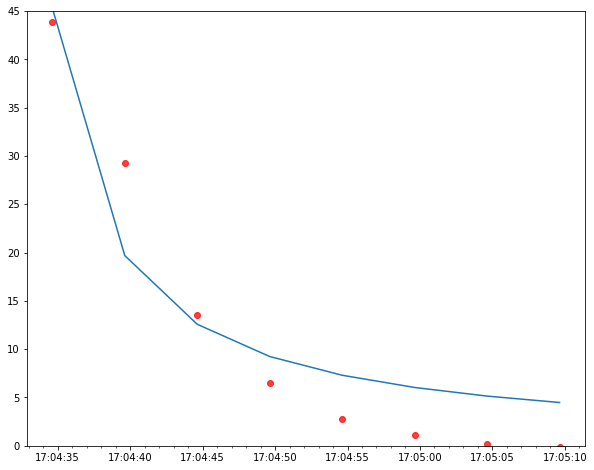

In [34]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot_date(stm_d,vr,'r' 'o',alpha=0.75)
ax.plot_date(stm_d,u0_fit(tt,*popt),'-')
#ax.plot_date(stm_d,vb,'b',alpha=0.75,marker='o')
#ax.xaxis.set_major_locator(date.MinuteLocator())
#ax.xaxis.set_major_locator(tmp[1420:1430])
ax.xaxis.set_major_formatter(date.DateFormatter('%H:%M:%S'))
ax.xaxis.set_minor_locator(date.SecondLocator())
#ax.xaxis.set_minor_formatter(date.DateFormatter('0.%f'))
ax.set_ylim(0,45)
#ax.set_xlim([tmp[1420], tmp[1430]])

#plt.plot(stm,u0_fit(stm,*popt),'-')
#plt.plot(stm,vr,'r' 'o')

In [35]:
str0 = -25566.287457025464 # from fit_iris

In [36]:
stm_d[0]

-25566.28848804398

# IRIS fit data
(need to run fit_iris.ipynb first!)

In [37]:
%store -r vr_fit
%store -r vr_iris
%store -r stm

In [38]:
firis = interp1d(stm,vr_fit,kind='cubic')
tiris = np.linspace(stm[0], stm[-1], num=51, endpoint=True)

In [39]:
import matplotlib as mpl
import matplotlib.font_manager as fm
# Rebuild the matplotlib font cache
fm._rebuild()

mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

clrs = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#93003a']

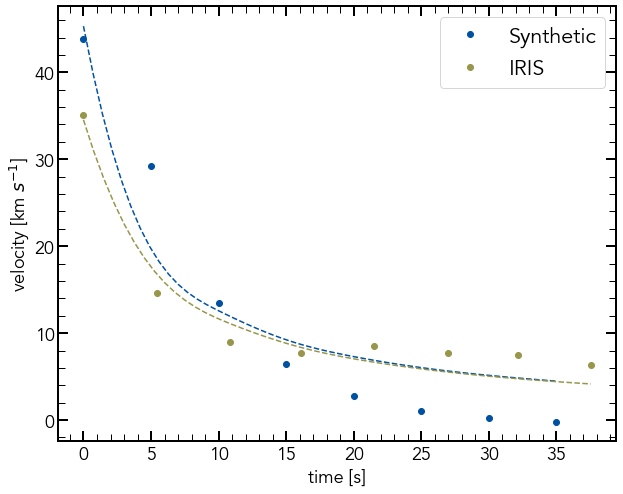

In [40]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(tt,vr,'o',label='Synthetic', color = clrs[0])
ax.plot(tnew,f(tnew), '--', color = clrs[0])
ax.plot(stm,vr_iris,'o',label='IRIS', color = clrs[1])
ax.plot(tiris,firis(tiris), '--', color = clrs[1])

ax.set_xlabel('time [s]')
ax.set_ylabel('velocity [km $s^{-1}$]')
ax.legend(fontsize='large')

ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=1, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=1, direction='in', right='on')

ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

#ax.set_xlim(-0.5, 40)
#ax.set_ylim(-1.5, 50)

#plt.savefig('IRIS_PREFT_velocities.png')
#fig.savefig('test.svg', format='svg', dpi=1200)